# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data (Loading MNist and "Binarize" it)

In [4]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Binarize the dataset
x_train = tf.where(x_train >= 128, 1, 0)
x_test = tf.where(x_test >= 128, 1, 0)

# Flatten the images
x_train = tf.reshape(x_train, [-1, 784])
x_test = tf.reshape(x_test, [-1, 784])

# Create a tf.data.Dataset from the training data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)

# Set the batch size
m = 256

# Create batches of size m
train_dataset = train_dataset.batch(m).repeat()

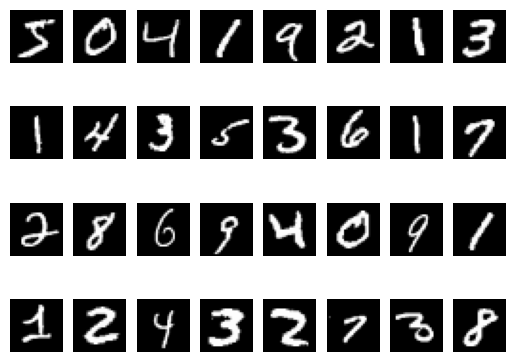

In [5]:
# Take one batch of the dataset
for images in train_dataset.take(1):
    # Reshape the images back to their original shape
    images = tf.reshape(images, [-1, 28, 28])
    
    # Plot the images
    fig, axes = plt.subplots(4, 8)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.show()

# The Real Deal

## Global declaration

In [ ]:
n_hidden = 128
k_gibbs_steps = 50
learning_rate = 0.001
train_iters = 200

b = tf.Variable(np.random.uniform(-.5, .5, size=(784, 1)))
c = tf.Variable(np.random.uniform(-.5, .5, size=(n_hidden, 1)))
W = tf.Variable(np.random.uniform(-.5, .5, size=(784, n_hidden)))

## Positive Phase 

In [ ]:
def sample_H_given_V(V):
  VW = tf.matmul(V, W)
  c_broadcasted = tf.broadcast_to(tf.transpose(c), tf.shape(VW))
  return tf.nn.sigmoid(VW + c_broadcasted) # 64*784 x 784 x 100 + (64*100) - This works!
def sample_V_given_H(H):
  HW = tf.matmul(H, tf.transpose(W))
  c_broadcasted = tf.broadcast_to(tf.transpose(b), tf.shape(HW))
  return tf.nn.sigmoid(HW + c_broadcasted)
  # return np.asarray(tf.nn.sigmoid(tf.matmul(H,tf.transpose(W))+c))
def energy_function_single_input(v,h): #This is working for single inputs, can be used to verify future results
  return -tf.matmul(tf.transpose(b),v)-tf.matmul(tf.transpose(c),h)-tf.matmul(tf.matmul(tf.transpose(v),W),h) 
def energy_function_batch(V,H): # This is producing the same results as the single function.
  return -tf.matmul(V,b)-tf.matmul(H,c)-tf.reduce_sum(tf.matmul(V, W) * H, axis=1)

In [ ]:
def positive_training(data):
  with tf.GradientTape() as tape:
    tape.watch([W,b,c])
    V = tf.constant(tf.cast(data, tf.float64), dtype=tf.float64)
    print(tf.math.reduce_mean(sample_H_given_V(V)))
    H = tf.constant(tf.cast(tfd.Bernoulli(probs=sample_H_given_V(V)).sample(), tf.float64), dtype=tf.float64)
    E = -energy_function_batch(V,H)
    #print("Energy, positive training: {}".format(E))

  grads = tape.gradient(E, [W,b,c])
  return V,H,grads

## Negative Phase (Buuuuuh)

In [ ]:
def negative_training_basic():
    #1. Get m samples

    # Create an m x 784 array of random values
    V_mc = tf.random.uniform((m, 784), dtype=tf.float64)

    # Normalize the columns so that they sum to 1
    V_mc = V_mc / tf.reduce_sum(V_mc, axis=0)

    with tf.GradientTape() as tape:
        H = []
        tape.watch([W,b,c])
        for i in range(k_gibbs_steps):
            # 1: Given V, calc H:
            H = tf.cast(tfd.Bernoulli(probs=sample_H_given_V(V_mc)).sample(), tf.float64)
            V_mc = tf.cast(tfd.Bernoulli(probs=sample_V_given_H(H)).sample(), tf.float64)
            E = -energy_function_batch(V_mc,H)
            #print("Energy, negative training: {}".format(E))
    grads = tape.gradient(E,[W,b,c])
    return V_mc, H, grads

In [ ]:
def negative_training_cd(data):
     #1. Get m samples

    # Create an m x 784 array of random values
    V_mc = tf.constant(tf.cast(data, tf.float64), dtype=tf.float64)

    with tf.GradientTape() as tape:
        H = []
        tape.watch([W,b,c])
        for i in range(k_gibbs_steps):
            # 1: Given V, calc H:
            H = tf.cast(tfd.Bernoulli(probs=sample_H_given_V(V_mc)).sample(), tf.float64)
            V_mc = tf.cast(tfd.Bernoulli(probs=sample_V_given_H(H)).sample(), tf.float64)
            E = -energy_function_batch(V_mc,H)
            #print("Energy, negative training: {}".format(E))
    grads = tape.gradient(E,[W,b,c])
    return V_mc, H, grads

In [ ]:
def negative_training_pcd(V_prev):
    if V_prev is None:
        # Create an m x 784 array of random values
        V_prev = tf.random.uniform((m, 784), dtype=tf.float64)

        # Normalize the columns so that they sum to 1
        V_prev = V_prev / tf.reduce_sum(V_prev, axis=0)
    with tf.GradientTape() as tape:
        H = []
        tape.watch([W,b,c])
        for i in range(k_gibbs_steps):
            # 1: Given V, calc H:
            H = tf.cast(tfd.Bernoulli(probs=sample_H_given_V(V_prev)).sample(), tf.float64)
            V_prev = tf.cast(tfd.Bernoulli(probs=sample_V_given_H(H)).sample(), tf.float64)
            E = -energy_function_batch(V_prev,H)
            #print("Energy, negative training: {}".format(E))
    grads = tape.gradient(E,[W,b,c])
    return V_prev, H, grads

## Putting everything together + Updating parameters

In [ ]:
V_n = None
for i, data in enumerate(train_dataset):
    V_p, H_p, grads_p = positive_training(data)
    #V_n, H_n, grads_n = negative_training_pcd(V_n)
    V_n, H_n, grads_n = negative_training_cd(data)


    W_grad = (grads_p[0] - grads_n[0])/m
    b_grad = (grads_p[1] - grads_n[1])/m
    c_grad = (grads_p[2] - grads_n[2])/m

    W = W + learning_rate*W_grad
    b = b + learning_rate*b_grad
    c = c + learning_rate*c_grad
    print(i)
    if i==train_iters:
        break


tf.Tensor(0.5301967568930442, shape=(), dtype=float64)
0
tf.Tensor(0.1403471855988794, shape=(), dtype=float64)
1
tf.Tensor(0.11772701755574999, shape=(), dtype=float64)
2
tf.Tensor(0.1619016705729972, shape=(), dtype=float64)
3
tf.Tensor(0.2022560531092928, shape=(), dtype=float64)
4
tf.Tensor(0.09210740408771612, shape=(), dtype=float64)
5
tf.Tensor(0.14140202657315576, shape=(), dtype=float64)
6
tf.Tensor(0.12739541974460802, shape=(), dtype=float64)
7
tf.Tensor(0.18078435325168724, shape=(), dtype=float64)
8
tf.Tensor(0.11756288076103996, shape=(), dtype=float64)
9
tf.Tensor(0.15981934635456946, shape=(), dtype=float64)
10
tf.Tensor(0.11890613742419642, shape=(), dtype=float64)
11
tf.Tensor(0.17242143068192117, shape=(), dtype=float64)
12
tf.Tensor(0.1342495907527881, shape=(), dtype=float64)
13
tf.Tensor(0.16343510582022402, shape=(), dtype=float64)
14
tf.Tensor(0.09492149745996789, shape=(), dtype=float64)
15
tf.Tensor(0.11405935004995132, shape=(), dtype=float64)
16
tf.Tensor(0.

## Let's do some sampling now!

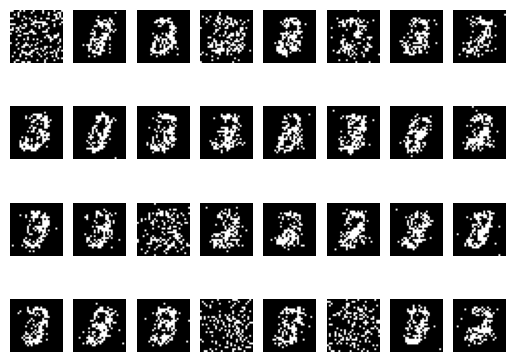

In [ ]:
 # Create an m x 784 array of random values
V_mc = tf.random.uniform((32, 784), dtype=tf.float64)

# Normalize the columns so that they sum to 1
V_mc = V_mc / tf.reduce_sum(V_mc, axis=0)
H = []
for i in range(k_gibbs_steps):
    # 1: Given V, calc H:
    H = tf.cast(tfd.Bernoulli(probs=sample_H_given_V(V_mc)).sample(), tf.float64)
    V_mc = tf.cast(tfd.Bernoulli(probs=sample_V_given_H(H)).sample(), tf.float64)

x_reshaped = tf.reshape(V_mc, (32, 28, 28))
# Create a figure and axes
fig, axes = plt.subplots(4, 8)

# Loop over the rows and columns of the grid
for i in range(4):
    for j in range(8):
        # Get the index of the image to display
        index = i * 8 + j
        
        # Display the image on the current axis
        axes[i, j].imshow(x_reshaped[index], cmap='gray')
        axes[i, j].axis('off')

# Show the figure
plt.show()
